In [12]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from functools import wraps
import os
import re
from opencc import OpenCC

In [13]:
MODEL_OBJECT = 'cut_result_bak'
def load_model():
    """加载模型"""
    model = Word2Vec.load(MODEL_OBJECT)
    return model

In [14]:
def stopwords(line):
    # 处理停止词
    with open(STOP_WORD, 'r') as fr:
        words = fr.read()
    res = [x for x in line if x not in words]
    return res


def decorator(func):
    """记录执行时间"""
    @wraps(func)
    def wrap():
        start_time = time.time()
        logger.info('进入{}函数，开始时间：{}'.format(func.__name__, start_time))
        func()
        logger.info('{}函数执行结束，总用时时间：{}'.format(func.__name__ ,str(time.time() - start_time)))
        logger.info('*'*50 + '分割线' + '*'*50)
    return wrap


@decorator
def cut_word():
    """分词"""
    cc = OpenCC('hk2s')
    for file_name in os.listdir(CORPUS):
        res = re.search('^\.', file_name)
        if file_name == 'cut_result':
            break
        if file_name not in  ['.DS_Store', 'cut_result', 'cut_result_bak'] and not res:
            with open(CORPUS+file_name, 'r') as fr:
                rds = fr.readlines()
                logger.info('当前文件行数: {}'.format(len(rds)))
                with open(CUT_RESULT, 'a') as fw:
                    for r in rds:
                        re_filter = re.findall('<doc id=.*>|</doc>', r)
                        if not re_filter:
                            clean_word = ' '.join(stopwords(jieba.lcut(cc.convert(r))))
                            if clean_word:
                                fw.write(clean_word)
                        else:
                            logger.info('过滤字符: {}'.format(re_filter[0]))


@decorator
def train_model():
    """训练模型"""
    sentences = gensim.models.word2vec.LineSentence(CUT_RESULT)
    model = gensim.models.word2vec.Word2Vec(sentences, size=100, hs=1, min_count=200, window=3)
    model.save(MODEL_OBJECT)
    try:
        sim1 = model.similarity('初等数学', '代数')
    except KeyError:
        sim1 = 0
    print(sim1)

In [15]:
def tsne_plot(model):
    """画图"""
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    tokens = tokens[:500]
    labels = labels[:500]
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:

        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

In [19]:
model = load_model()

In [20]:
sim1 = model.similarity('爱情', '友情')
sim2 = model.most_similar(['世界杯'])
print(sim1)
print(sim2)

0.697083
[('亚洲杯', 0.8105554580688477), ('欧锦赛', 0.751886248588562), ('欧洲杯', 0.7091526985168457), ('分组赛', 0.672939658164978), ('欧联', 0.6691690683364868), ('德国队', 0.6663553714752197), ('U20', 0.6544479131698608), ('法国队', 0.6511896252632141), ('U19', 0.6503055691719055), ('决赛圈', 0.6412535905838013)]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


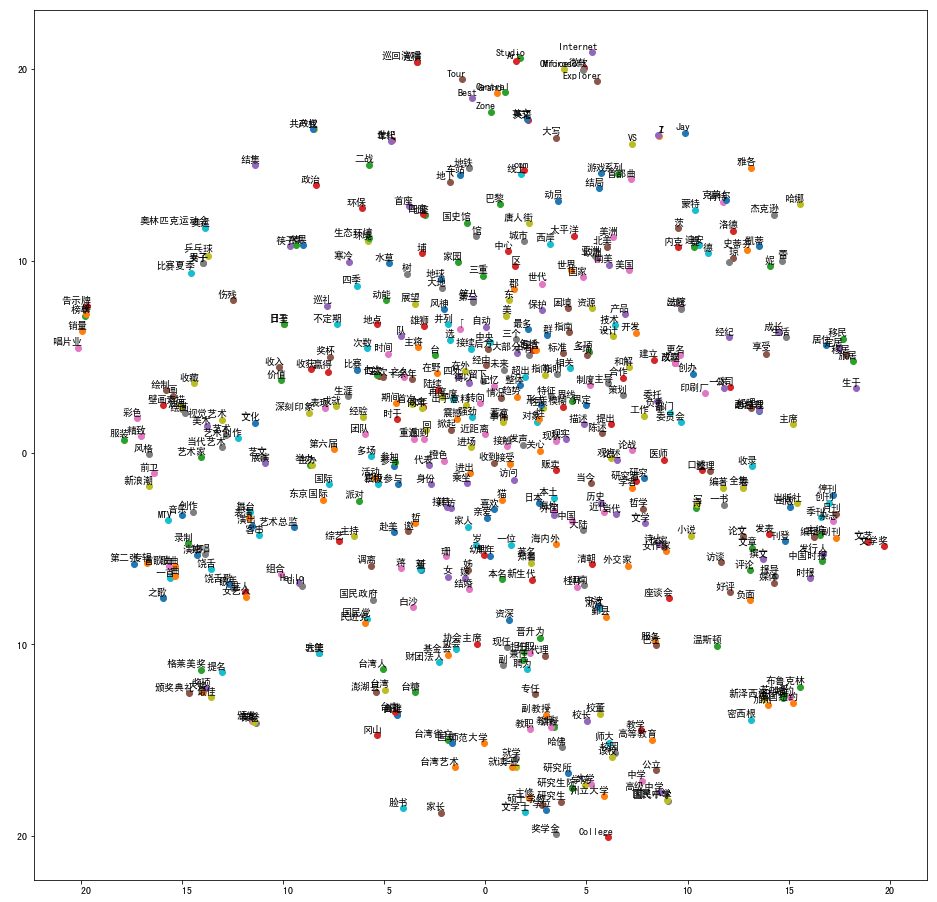

In [21]:
tsne_plot(model)